In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, AUC
from tensorflow.math import confusion_matrix
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix , roc_curve, precision_recall_curve, average_precision_score



In [ ]:
# Define paths to your dataset
train_dir = '/content/drive/MyDrive/Dataset/train'
test_dir = '/content/drive/MyDrive/Dataset/Test'

In [ ]:
# Define image dimensions
image_size = (224, 224)
batch_size = 32

In [ ]:
# Data preprocessing and augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)  # Disable shuffling to maintain order

Found 611 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)  # Disable shuffling to maintain order


Found 621 images belonging to 2 classes.


In [ ]:
# Get the labels for the training set
train_labels = []
for i in range(len(train_generator.filenames)):
    label = train_generator.classes[i]
    train_labels.append(label)



In [ ]:
# Get the labels for the test set
test_labels = []
for i in range(len(test_generator.filenames)):
    label = test_generator.classes[i]
    test_labels.append(label)



In [ ]:
# Define the EfficientNetV2B0 model
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=base_model.input, outputs=output)


24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define callback to save the best model
checkpoint_callback = callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 verbose=1)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint_callback])


Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.8221
Epoch 1: val_loss improved from inf to 0.54653, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 312s 16s/step - loss: 0.4856 - accuracy: 0.8221 - val_loss: 0.5465 - val_accuracy: 0.8043
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.8083
Epoch 2: val_loss improved from 0.54653 to 0.51979, saving model to best_model.h5
19/19 [==============================] - 84s 4s/step - loss: 0.5405 - accuracy: 0.8083 - val_loss: 0.5198 - val_accuracy: 0.8043
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.8342
Epoch 3: val_loss improved from 0.51979 to 0.49527, saving model to best_model.h5
19/19 [==============================] - 84s 5s/step - loss: 0.4574 - accuracy: 0.8342 - val_loss: 0.4953 - val_accuracy: 0.8043
Epoch 4/10
19/19 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.8083
Epoch 4: val_loss improved from 0.49527 to 0.49509, saving model to best_model.h5
19/19 [==============================] - 76s 4s/step - loss: 0.5105 - accuracy: 0.8

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


20/20 [==============================] - 34s 2s/step - loss: 0.5006 - accuracy: 0.8084
Test Loss: 0.500597357749939
Test Accuracy: 0.8083735704421997


In [ ]:


# Predict labels for test set
predicted_labels = model.predict(test_generator)
predicted_labels = np.round(predicted_labels).flatten()  # Convert probabilities to binary labels

# True labels for the test set
true_labels = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)


20/20 [==============================] - 34s 2s/step
Confusion Matrix:
[[  0 119]
 [  0 502]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
# Predict labels for test set
predicted_probs = model.predict(test_generator)
predicted_labels = np.round(predicted_probs).flatten()  # Convert probabilities to binary labels

# True labels for the test set
true_labels = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Extract TP, FP, TN, FN from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate AUC
auc = roc_auc_score(true_labels, predicted_probs)

# Print metrics
print("Binary Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("True Positives:", tp)
print("False Positives:", fp)
print("True Negatives:", tn)
print("False Negatives:", fn)
print("AUC:", auc)

20/20 [==============================] - 32s 2s/step
Binary Accuracy: 0.8083735909822867
Precision: 0.8083735909822867
Recall: 1.0
True Positives: 502
False Positives: 119
True Negatives: 0
False Negatives: 0
AUC: 0.51547591148013


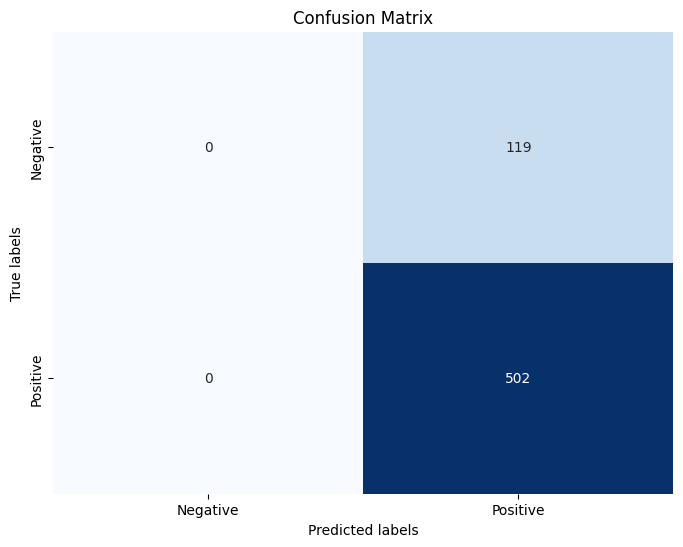

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

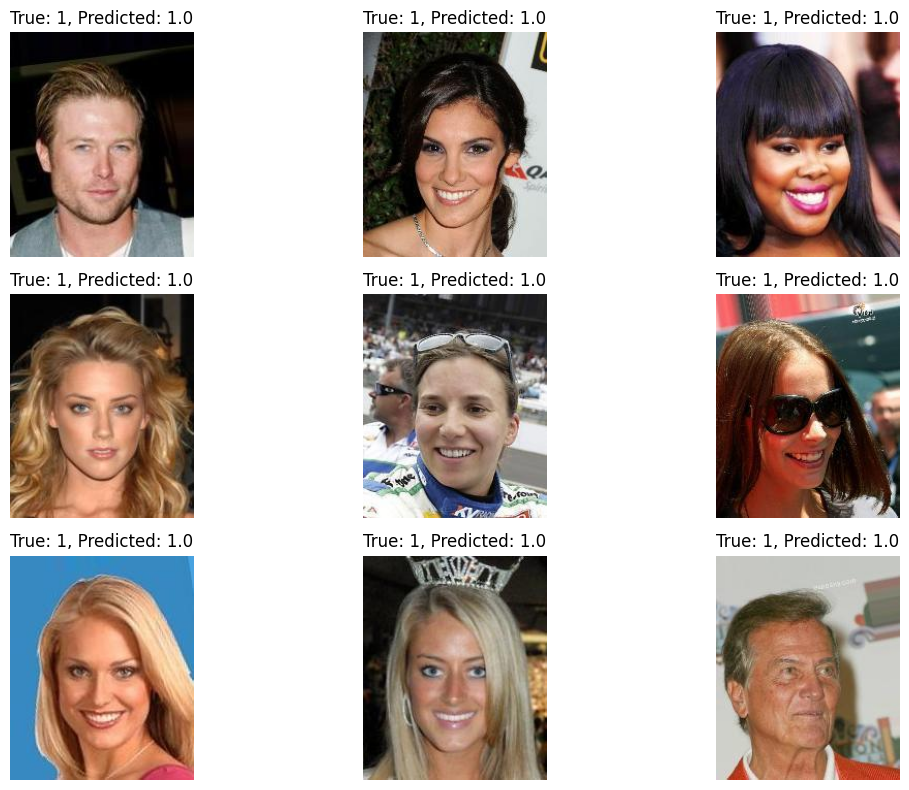

In [ ]:
import matplotlib.pyplot as plt

# Predict labels for a subset of test set
subset_size = 9  # Number of images to display
subset_indices = np.random.choice(len(test_generator.filenames), subset_size, replace=False)
subset_images = []
subset_true_labels = []
subset_predicted_labels = []

for index in subset_indices:
    img_path = os.path.join(test_dir, test_generator.filenames[index])
    img = plt.imread(img_path)
    subset_images.append(img)
    subset_true_labels.append(test_generator.classes[index])
    subset_predicted_labels.append(np.round(predicted_labels[index]))

# Plot labeled images
plt.figure(figsize=(12, 8))
for i in range(subset_size):
    plt.subplot(3, 3, i + 1)
    plt.imshow(subset_images[i])
    plt.title(f'True: {subset_true_labels[i]}, Predicted: {subset_predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


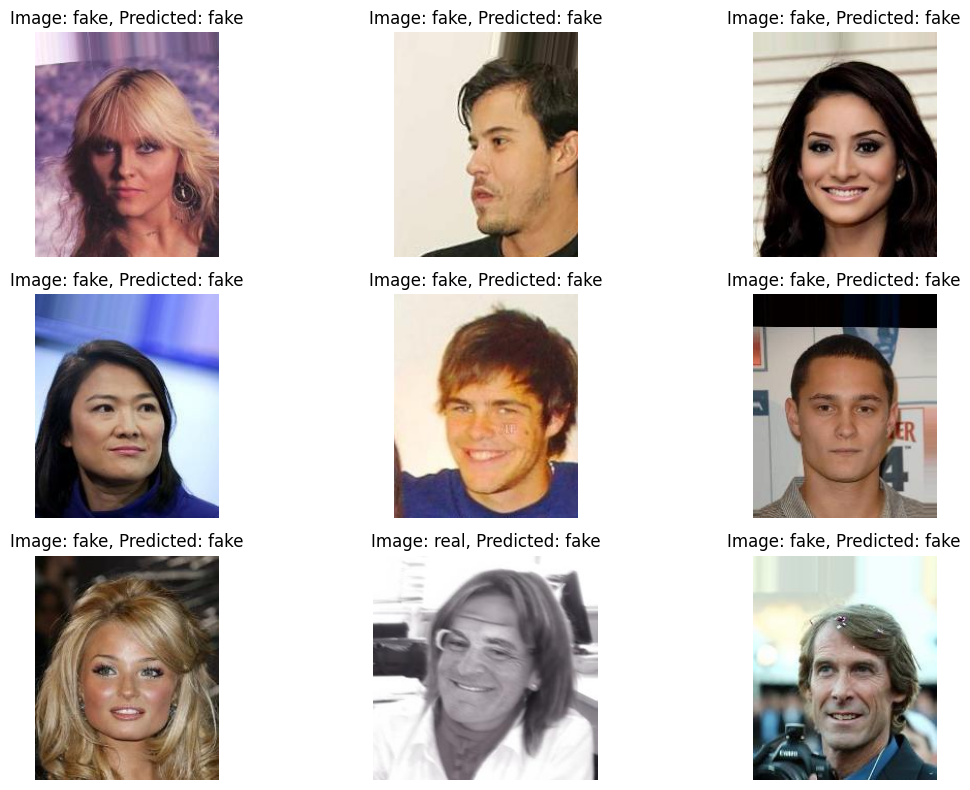

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Map class indices to class labels
class_labels = {0: "real", 1: "fake"}

# Predict labels for a subset of test set
subset_size = 9# Number of images to display
subset_indices = np.random.choice(len(test_generator.filenames), subset_size, replace=False)
subset_images = []
subset_true_labels = []
subset_predicted_labels = []

for index in subset_indices:
    img_path = os.path.join(test_dir, test_generator.filenames[index])
    img = plt.imread(img_path)
    subset_images.append(img)
    true_label = class_labels[test_generator.classes[index]]
    subset_true_labels.append(true_label)
    predicted_label = class_labels[np.round(predicted_labels[index]).astype(int)]
    subset_predicted_labels.append(predicted_label)

# Plot labeled images
plt.figure(figsize=(12, 8))
for i in range(subset_size):
    plt.subplot(3, 3, i + 1)
    plt.imshow(subset_images[i])
    plt.title(f'Image: {subset_true_labels[i]}, Predicted: {subset_predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('best_model.h5')  # Provide the path to your HDF5 model file

# Define class labels
class_labels = {0: "real", 1: "fake"}  # Assuming 0 is real and 1 is fake

# Load and preprocess the image
img_path = '/content/drive/MyDrive/Dataset/train/fake/fake_1010.jpg'  # Provide the path to your image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to match model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize pixel values

# Make prediction
prediction = model.predict(img_array)
predicted_label = np.round(prediction).astype(int)[0][0]
predicted_class = class_labels[predicted_label]
print("Prediction", prediction)
print("Predicted class:", predicted_class)


1/1 [==============================] - 2s 2s/step
Prediction [[0.8079909]]
Predicted class: fake


In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

Writing app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

104.196.26.141


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://104.196.26.141:8501

npx: installed 22 in 6.9s
your url is: https://solid-books-rest.loca.lt
2024-03-09 05:39:46.591300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 05:39:46.591373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 05:39:46.593073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 05:39:48.157955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1/1 [======================